<a href="https://colab.research.google.com/github/PCBZ/BrainTumorDetection/blob/dev_approach1/src/CS6140_project_approach1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import kagglehub

class DataPreprocessor:
    @staticmethod
    def organize_data(source_path, target_path='/content/brain_tumor_split', test_size=0.2):
        all_images, all_labels = [], []
        for class_name in ['yes', 'no']:
            class_path = os.path.join(source_path, class_name)
            for image in os.listdir(class_path):
                all_images.append(os.path.join(class_path, image))
                all_labels.append(class_name)

        X_train, X_test, y_train, y_test = train_test_split(
            all_images, all_labels, test_size=test_size, stratify=all_labels, random_state=42
        )

        for split, (images, labels) in [('train', (X_train, y_train)), ('test', (X_test, y_test))]:
            for class_name in ['yes', 'no']:
                os.makedirs(os.path.join(target_path, split, class_name), exist_ok=True)
            for image, label in zip(images, labels):
                shutil.copy(image, os.path.join(target_path, split, label))

        return target_path

class DataLoaderHelper:
    @staticmethod
    def load_data(data_dir, image_size=(224, 224), batch_size=16, num_workers=2):
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        }

        image_datasets = {
            x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
            for x in ['train', 'test']
        }
        dataloaders = {
            x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers)
            for x in ['train', 'test']
        }

        train_labels = [label for _, label in image_datasets['train']]
        class_counts = torch.bincount(torch.tensor(train_labels))
        class_weights = 1.0 / class_counts.float()
        class_weights = class_weights / class_weights.sum() * 2

        return dataloaders, class_weights, image_datasets

class DataUtils:
    @staticmethod
    def load_brain_tumor_data_pipeline(dataset_url='navoneel/brain-mri-images-for-brain-tumor-detection',
                                        target_path='/content/brain_tumor_data'):
        path = kagglehub.dataset_download(dataset_url)
        target_path = DataPreprocessor.organize_data(path, target_path)
        dataloaders, class_weights, image_datasets = DataLoaderHelper.load_data(target_path)
        return dataloaders, class_weights, image_datasets

# Load data
dataloaders, class_weights, image_datasets = DataUtils.load_brain_tumor_data_pipeline()
print(f"Train samples: {len(image_datasets['train'])}")
print(f"Test samples: {len(image_datasets['test'])}")
print(f"Class weights: {class_weights}")

Train samples: 202
Test samples: 51
Class weights: tensor([1.2277, 0.7723])


In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BrainTumorCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BrainTumorCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate * 0.5),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate * 0.7),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, 1)
        )

        # Training attributes
        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

    def train_epoch(self, loader, criterion, optimizer, class_weights=None):
        self.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in tqdm(loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = self(inputs).squeeze()
            loss = criterion(outputs, labels)

            if class_weights is not None:
                weights = class_weights[labels.long()]
                loss = (loss * weights).mean()

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        return total_loss / len(loader), 100. * correct / total

    def validate_epoch(self, loader, criterion):
        self.eval()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = self(inputs).squeeze()
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return total_loss / len(loader), 100. * correct / total, all_preds, all_labels

    def train_model(self, train_loader, val_loader, epochs, lr, optimizer_type='adam',
                   class_weights=None, patience=15):
        self.to(device)
        criterion = nn.BCEWithLogitsLoss()

        if class_weights is not None:
            class_weights = class_weights.to(device)

        optimizers = {
            'adam': optim.Adam(self.parameters(), lr=lr, weight_decay=1e-4),
            'sgd': optim.SGD(self.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4),
            'rmsprop': optim.RMSprop(self.parameters(), lr=lr, weight_decay=1e-4)
        }
        optimizer = optimizers[optimizer_type]
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            train_loss, train_acc = self.train_epoch(train_loader, criterion, optimizer, class_weights)
            val_loss, val_acc, val_preds, val_labels = self.validate_epoch(val_loader, criterion)

            scheduler.step(val_loss)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)

            print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
            print(f"Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = self.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return val_preds, val_labels

Starting Custom CNN Training
Focus: CNN Architecture & Hyperparameter Optimization

Using parameters: {'dropout_rate': 0.07, 'learning_rate': 0.001, 'optimizer': 'adam', 'epochs': 100, 'patience': 15}

Training final model...

Epoch 1/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.78it/s]


Train: Loss=0.6242, Acc=62.87%
Val: Loss=0.6628, Acc=68.63%

Epoch 2/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]


Train: Loss=0.5453, Acc=74.75%
Val: Loss=1.0697, Acc=74.51%

Epoch 3/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Train: Loss=0.5239, Acc=75.25%
Val: Loss=0.4673, Acc=76.47%

Epoch 4/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.81it/s]


Train: Loss=0.4635, Acc=78.71%
Val: Loss=0.6008, Acc=72.55%

Epoch 5/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]


Train: Loss=0.4459, Acc=75.25%
Val: Loss=0.5070, Acc=74.51%

Epoch 6/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


Train: Loss=0.4305, Acc=78.71%
Val: Loss=0.4152, Acc=76.47%

Epoch 7/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Train: Loss=0.5001, Acc=74.75%
Val: Loss=0.7635, Acc=70.59%

Epoch 8/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.03it/s]


Train: Loss=0.4389, Acc=79.70%
Val: Loss=0.5185, Acc=72.55%

Epoch 9/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


Train: Loss=0.3913, Acc=85.15%
Val: Loss=0.6803, Acc=64.71%

Epoch 10/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.05it/s]


Train: Loss=0.3804, Acc=81.68%
Val: Loss=0.4448, Acc=78.43%

Epoch 11/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Train: Loss=0.4121, Acc=81.68%
Val: Loss=0.6998, Acc=68.63%

Epoch 12/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


Train: Loss=0.4225, Acc=79.21%
Val: Loss=0.4351, Acc=80.39%

Epoch 13/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.09it/s]


Train: Loss=0.3836, Acc=83.66%
Val: Loss=0.6318, Acc=72.55%

Epoch 14/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s]


Train: Loss=0.3748, Acc=82.18%
Val: Loss=0.4678, Acc=74.51%

Epoch 15/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]


Train: Loss=0.3781, Acc=82.18%
Val: Loss=0.4647, Acc=76.47%

Epoch 16/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Train: Loss=0.3595, Acc=86.63%
Val: Loss=0.4149, Acc=78.43%

Epoch 17/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.68it/s]


Train: Loss=0.3665, Acc=84.16%
Val: Loss=0.3908, Acc=74.51%

Epoch 18/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.41it/s]


Train: Loss=0.3518, Acc=85.15%
Val: Loss=0.4243, Acc=76.47%

Epoch 19/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


Train: Loss=0.4141, Acc=83.17%
Val: Loss=0.4685, Acc=80.39%

Epoch 20/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]


Train: Loss=0.3693, Acc=81.68%
Val: Loss=0.3537, Acc=84.31%

Epoch 21/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s]


Train: Loss=0.3482, Acc=85.64%
Val: Loss=0.6304, Acc=80.39%

Epoch 22/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s]


Train: Loss=0.3695, Acc=84.65%
Val: Loss=0.5507, Acc=78.43%

Epoch 23/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.05it/s]


Train: Loss=0.3788, Acc=84.16%
Val: Loss=0.3528, Acc=80.39%

Epoch 24/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Train: Loss=0.3077, Acc=86.63%
Val: Loss=0.5109, Acc=80.39%

Epoch 25/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


Train: Loss=0.3829, Acc=83.17%
Val: Loss=0.4548, Acc=78.43%

Epoch 26/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


Train: Loss=0.3153, Acc=85.15%
Val: Loss=0.3649, Acc=78.43%

Epoch 27/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.86it/s]


Train: Loss=0.2822, Acc=88.61%
Val: Loss=0.4829, Acc=84.31%

Epoch 28/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]


Train: Loss=0.3225, Acc=84.16%
Val: Loss=0.6328, Acc=86.27%

Epoch 29/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


Train: Loss=0.3531, Acc=85.15%
Val: Loss=0.4863, Acc=76.47%

Epoch 30/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.76it/s]


Train: Loss=0.3156, Acc=87.13%
Val: Loss=0.5115, Acc=78.43%

Epoch 31/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.61it/s]


Train: Loss=0.3039, Acc=85.64%
Val: Loss=0.4159, Acc=80.39%

Epoch 32/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Train: Loss=0.2739, Acc=88.61%
Val: Loss=0.3985, Acc=80.39%

Epoch 33/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]


Train: Loss=0.2406, Acc=89.60%
Val: Loss=0.4577, Acc=80.39%

Epoch 34/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Train: Loss=0.2581, Acc=88.12%
Val: Loss=0.6170, Acc=80.39%

Epoch 35/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]


Train: Loss=0.3056, Acc=86.14%
Val: Loss=0.3754, Acc=84.31%

Epoch 36/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]


Train: Loss=0.2754, Acc=87.62%
Val: Loss=0.4141, Acc=82.35%

Epoch 37/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Train: Loss=0.2499, Acc=87.62%
Val: Loss=0.3456, Acc=86.27%

Epoch 38/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.66it/s]


Train: Loss=0.2344, Acc=90.59%
Val: Loss=0.5060, Acc=86.27%

Epoch 39/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s]


Train: Loss=0.2491, Acc=88.61%
Val: Loss=0.3838, Acc=88.24%

Epoch 40/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 10.83it/s]


Train: Loss=0.3001, Acc=85.15%
Val: Loss=0.3781, Acc=80.39%

Epoch 41/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]


Train: Loss=0.3017, Acc=88.12%
Val: Loss=0.4210, Acc=84.31%

Epoch 42/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]


Train: Loss=0.2550, Acc=89.60%
Val: Loss=0.4311, Acc=84.31%

Epoch 43/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Train: Loss=0.2358, Acc=88.12%
Val: Loss=0.5111, Acc=82.35%

Epoch 44/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]


Train: Loss=0.2678, Acc=86.63%
Val: Loss=0.3627, Acc=86.27%

Epoch 45/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.04it/s]


Train: Loss=0.2585, Acc=89.60%
Val: Loss=0.3954, Acc=84.31%

Epoch 46/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.38it/s]


Train: Loss=0.2334, Acc=89.60%
Val: Loss=0.5394, Acc=82.35%

Epoch 47/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.85it/s]


Train: Loss=0.2754, Acc=88.12%
Val: Loss=0.3629, Acc=80.39%

Epoch 48/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]


Train: Loss=0.2520, Acc=89.60%
Val: Loss=0.3282, Acc=84.31%

Epoch 49/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.49it/s]


Train: Loss=0.2003, Acc=93.07%
Val: Loss=0.4104, Acc=82.35%

Epoch 50/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Train: Loss=0.2188, Acc=92.08%
Val: Loss=0.5055, Acc=84.31%

Epoch 51/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Train: Loss=0.2512, Acc=87.13%
Val: Loss=0.8883, Acc=84.31%

Epoch 52/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]


Train: Loss=0.2336, Acc=88.61%
Val: Loss=0.3164, Acc=82.35%

Epoch 53/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


Train: Loss=0.2292, Acc=92.57%
Val: Loss=0.3406, Acc=84.31%

Epoch 54/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Train: Loss=0.1962, Acc=93.07%
Val: Loss=0.3942, Acc=82.35%

Epoch 55/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


Train: Loss=0.2129, Acc=91.58%
Val: Loss=0.3631, Acc=82.35%

Epoch 56/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.04it/s]


Train: Loss=0.2468, Acc=90.10%
Val: Loss=0.3475, Acc=86.27%

Epoch 57/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.23it/s]


Train: Loss=0.2226, Acc=90.10%
Val: Loss=0.3561, Acc=84.31%

Epoch 58/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]


Train: Loss=0.2498, Acc=90.10%
Val: Loss=0.4074, Acc=82.35%

Epoch 59/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]


Train: Loss=0.2588, Acc=89.11%
Val: Loss=0.4678, Acc=82.35%

Epoch 60/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


Train: Loss=0.1853, Acc=93.07%
Val: Loss=0.3293, Acc=88.24%

Epoch 61/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


Train: Loss=0.2667, Acc=91.58%
Val: Loss=0.3356, Acc=88.24%

Epoch 62/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Train: Loss=0.1912, Acc=91.58%
Val: Loss=0.4424, Acc=88.24%

Epoch 63/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


Train: Loss=0.2125, Acc=90.59%
Val: Loss=0.3642, Acc=84.31%

Epoch 64/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]


Train: Loss=0.1860, Acc=92.57%
Val: Loss=0.3105, Acc=86.27%

Epoch 65/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.36it/s]


Train: Loss=0.2299, Acc=88.61%
Val: Loss=0.4576, Acc=88.24%

Epoch 66/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]


Train: Loss=0.1780, Acc=94.55%
Val: Loss=0.3381, Acc=88.24%

Epoch 67/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]


Train: Loss=0.1653, Acc=94.55%
Val: Loss=0.4140, Acc=86.27%

Epoch 68/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]


Train: Loss=0.1897, Acc=92.57%
Val: Loss=0.3501, Acc=88.24%

Epoch 69/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Train: Loss=0.2099, Acc=90.59%
Val: Loss=0.3184, Acc=84.31%

Epoch 70/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]


Train: Loss=0.2007, Acc=91.58%
Val: Loss=0.4667, Acc=88.24%

Epoch 71/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s]


Train: Loss=0.3724, Acc=80.69%
Val: Loss=0.3294, Acc=88.24%

Epoch 72/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Train: Loss=0.1814, Acc=93.56%
Val: Loss=0.3879, Acc=82.35%

Epoch 73/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


Train: Loss=0.2012, Acc=90.10%
Val: Loss=0.3386, Acc=86.27%

Epoch 74/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]


Train: Loss=0.2172, Acc=91.09%
Val: Loss=0.3461, Acc=86.27%

Epoch 75/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


Train: Loss=0.2091, Acc=91.09%
Val: Loss=0.3397, Acc=86.27%

Epoch 76/100


Validating: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Train: Loss=0.1781, Acc=93.07%
Val: Loss=0.4782, Acc=86.27%

Epoch 77/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.16it/s]


Train: Loss=0.1920, Acc=90.59%
Val: Loss=0.3510, Acc=86.27%

Epoch 78/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s]


Train: Loss=0.1689, Acc=93.56%
Val: Loss=0.4104, Acc=86.27%

Epoch 79/100


Validating: 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]

Train: Loss=0.1576, Acc=94.06%
Val: Loss=0.3315, Acc=86.27%
Early stopping at epoch 79

Final evaluation...



EVALUATION RESULTS
ACCURACY: 0.8627
PRECISION: 0.9000
RECALL: 0.8710
F1: 0.8852
AUC: 0.9161


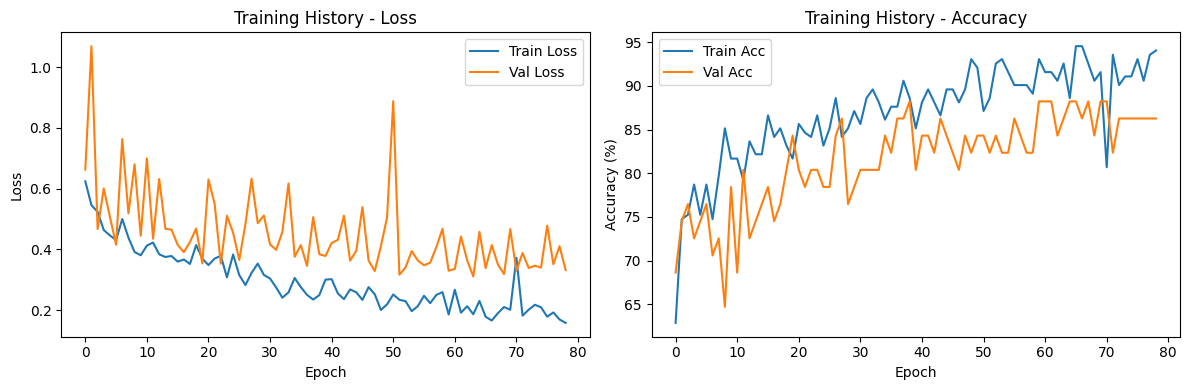

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs)

            all_preds.extend((probs > 0.5).float().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs)
    }

    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value:.4f}")

    return metrics

def plot_training_history(model):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(model.train_losses, label='Train Loss')
    plt.plot(model.val_losses, label='Val Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model.train_accs, label='Train Acc')
    plt.plot(model.val_accs, label='Val Acc')
    plt.title('Training History - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

params = {
    'dropout_rate': 0.07,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'epochs': 100,
    'patience': 15
}

print("Starting Custom CNN Training")
print("Focus: CNN Architecture & Hyperparameter Optimization")
print("=" * 60)

print(f"\nUsing parameters: {params}")

# Train final model with best parameters
print("\nTraining final model...")
model = BrainTumorCNN(dropout_rate=params['dropout_rate'])

model.train_model(
    dataloaders['train'], dataloaders['test'],
    epochs=params['epochs'], lr=params['learning_rate'],
    optimizer_type=params['optimizer'], class_weights=class_weights,
    patience=params['patience']
)

# Final evaluation
print("\nFinal evaluation...")
evaluate_model(model, dataloaders['test'])

# Plot training history
plot_training_history(model)